# LeNet for Traffic Sign
![LeNet Architecture](lenet.png)
Modified from source: Yan LeCun

Author: Peng "Patrick" Su

## Load Data

Load the traffic sign data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
%matplotlib inline

In [43]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../traffic-signs-data/train.p'
validation_file = '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [64]:
from skimage import transform, filters, exposure
import cv2
def augment_image(img,angle_range=(-5, 5),shear_range=10,trans_range=5,brightness=0):
    # rotation
    angle = np.random.uniform(*angle_range)
    rows, cols, _ = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)
    
    return img.astype(np.uint8)

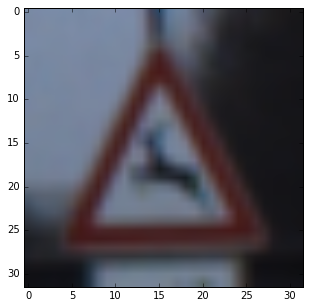

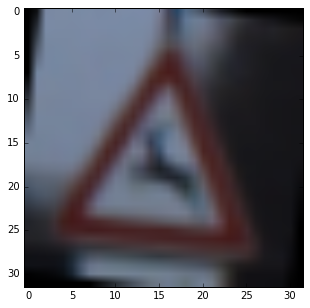

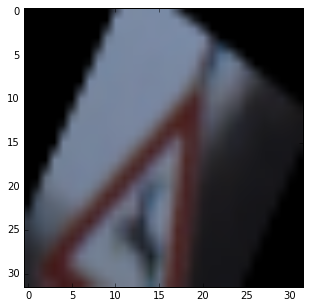

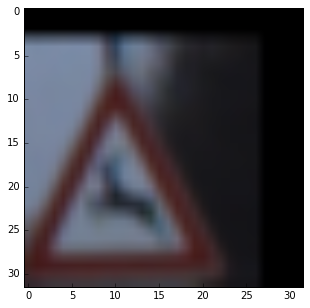

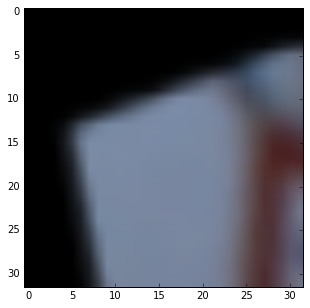

In [66]:
img = X_train[434]
aug1 = augment_image(img,angle_range=(-20, 20),shear_range=0,trans_range=0,brightness=0)
aug2 = augment_image(img,angle_range=(0, 0),shear_range=20,trans_range=0,brightness=0)
aug3 = augment_image(img,angle_range=(0, 0),shear_range=0,trans_range=20,brightness=0)
aug4 = augment_image(img,angle_range=(-20, 20),shear_range=20,trans_range=20,brightness=0)
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.figure(figsize=(5,5))
plt.imshow(aug1)
plt.figure(figsize=(5,5))
plt.imshow(aug2)
plt.figure(figsize=(5,5))
plt.imshow(aug3)
plt.figure(figsize=(5,5))
plt.imshow(aug4)

In [5]:
def augment_data(X, y):
    augmented_X = np.zeros([X.shape[0]*3, *X.shape[1:]], dtype = np.uint8)
    augmented_y = np.zeros([y.shape[0]*3, *y.shape[1:]], dtype = np.uint8)
    #print("X dtype : ", X.dtype)
    #print("augmented X dtype : ", augmented_X)
    for i, _ in enumerate(X):
        augmented_X[i] = X[i]
        augmented_y[i] = y[i]
        for j in range(1,3):
            augmented_X[i+j] = augment_image(X[i])
            augmented_y[i+j] = y[i]    
    return augmented_X, augmented_y
X_train, y_train = augment_data(X_train, y_train)

In [6]:
X_train.shape

(104397, 32, 32, 3)

In [7]:
X_train.dtype

dtype('uint8')

In [8]:
X_valid.shape

(4410, 32, 32, 3)

In [9]:
y_valid.shape

(4410,)

The traffic sign data comes as 32x32x3 images, and LeNet accepts 32x32xC images. No need to pad anything. 

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [10]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [11]:
def hist_eq(img):
    if (len(img.shape)>3): # if you're passing in a collection of images
        num_images = img.shape[0]
        image_shape = img.shape[1:]
        locEqImg = np.zeros([num_images,image_shape[0],image_shape[1],image_shape[2]])
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
        for i in range(num_images):
            #print("currImg dtype is ", img[i].dtype)
            #img[i] =img[i].astype(np.float32)
            currImg = img[i].squeeze()
            #img_yuv = cv2.cvtColor(currImg, cv2.COLOR_RGB2YUV)
            #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            #tmp = cv2.cvtColor(img_yuv, cv 2.COLOR_YUV2RGB)
            #eqImg[i]=tmp
            
            img_lab = cv2.cvtColor(currImg, cv2.COLOR_RGB2LAB)
            img_lab[:,:,0]=clahe.apply(img_lab[:,:,0])
            tmp = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
            locEqImg[i] = tmp
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img_lab[:,:,0]=clahe.apply(img_lab[:,:,0])
        tmp = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
        locEqImg = tmp
    return locEqImg
def normalize(img):
    return (img - 128.)/128.
def gray(img):
    if len(img.shape) > 3:
        ans = []
        for ig in img:
            ans.append(cv2.cvtColor(ig, cv2.COLOR_RGB2GRAY))
        return np.array(ans)
    else:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

X_train = hist_eq(X_train)
X_train = normalize(X_train)
# X_train = X_train.astype('float32')
# X_train = np.expand_dims(X_train, 3)

X_valid = hist_eq(X_valid)
X_valid = normalize(X_valid)
# X_valid = X_valid.astype('float32')
# X_valid = np.expand_dims(X_valid, 3)

X_test = hist_eq(X_test)
X_test = normalize(X_test)
# X_test = X_test.astype('float32')
# X_test = np.expand_dims(X_test, 3)

In [24]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

In [25]:
X_train.shape

(104397, 32, 32, 3)

In [26]:
X_train.dtype

dtype('float32')

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [14]:
import tensorflow as tf

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [34]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5,5,3,6], mu, sigma)),
        'wc2': tf.Variable(tf.truncated_normal([5,5,6,16], mu, sigma)),
        'wf3': tf.Variable(tf.truncated_normal([5*5*16, 120], mu, sigma)),
        'wf4': tf.Variable(tf.truncated_normal([120, 84], mu, sigma)),
        'wf5': tf.Variable(tf.truncated_normal([84, 43], mu, sigma))}
    biases = {
        'bc1': tf.zeros([6]),
        'bc2': tf.zeros([16]),
        'bf3': tf.zeros([120]),
        'bf4': tf.zeros([84]),
        'bf5': tf.zeros([43]),
    }
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv1 = tf.nn.bias_add(conv1, biases['bc1'])
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    conv1 = tf.nn.dropout(conv1, keep_prob)
#     flat1 = flatten(conv1, [-1, 14*14*6])
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2 = tf.nn.conv2d(conv1, weights['wc2'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv2 = tf.nn.bias_add(conv2, biases['bc2'])    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob)
    # TODO: Flatten. Input = 5x5x8. Output = 200.

#     flat2 = flatten(conv2, [-1, 5*5*16])
#     flat = tf.concat(1, [flat1, flat2])
    
    flat = flatten(conv2, [-1, 5*5*16])
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc3 = tf.add(tf.matmul(flat, weights['wf3']), biases['bf3'])
    # TODO: Activation.
    fc3 = tf.nn.relu(fc3)
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc4 = tf.add(tf.matmul(fc3, weights['wf4']), biases['bf4'])
    # TODO: Activation.
    fc4 = tf.nn.relu(fc4)
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc4, weights['wf5']), biases['bf5'])
    
    return logits

## Features and Labels
Train LeNet to classify traffic sign data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [37]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [38]:
rate = 0.001
logits = LeNet(x)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [39]:
saver = tf.train.Saver(max_to_keep=100)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [40]:
import shutil
save_dir = 'LeNetV4'
out_dir = out_dir = os.path.abspath(os.path.join(os.path.curdir, "../Traffic-Sign-Classifier-runs", save_dir))
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
train_summary_dir = os.path.join(out_dir, "train")        
valid_summary_dir = os.path.join(out_dir, "valid")
checkpoint_dir = os.path.join(out_dir, "checkpoints")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir,"model")
checkpoint_every = 1000
train_summary_every = 1000
valid_summary_every = 1000

EPOCHS = 40
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    global_step = 0
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
    valid_summary_writer = tf.summary.FileWriter(valid_summary_dir, sess.graph)
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.8})
            global_step += 1
#             if global_step % train_summary_every == 0:
#                 train_loss, train_accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
#                 train_summaries = tf.Summary()
#                 train_summaries.value.add(tag='Train Loss', simple_value=train_loss)
#                 train_summaries.value.add(tag='Train Accuracy', simple_value=train_accuracy)
#                 train_summary_writer.add_summary(train_summaries, global_step)
#                 print("Batch {} Train Loss: {:.3f} Train Accuracy: {:.3f}".format(global_step, train_loss, train_accuracy))
#                 print()
            if global_step % valid_summary_every == 0:
                validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
                valid_summaries = tf.Summary()
                valid_summaries.value.add(tag='Validation Loss', simple_value=validation_loss)
                valid_summaries.value.add(tag='Validation Accuracy', simple_value=validation_accuracy)
                print("valid writing")
                valid_summary_writer.add_summary(valid_summaries, global_step)
                print("EPOCH {} Batch {} ...".format(i+1, global_step))
                print("Validation loss = {:.3f}".format(validation_loss))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print()
            if global_step % checkpoint_every == 0:
                saver.save(sess, checkpoint_prefix, global_step=global_step)            
    print("Training Done")

Training...

valid writing
EPOCH 2 Batch 1000 ...
Validation loss = 0.365
Validation Accuracy = 0.891

valid writing
EPOCH 3 Batch 2000 ...
Validation loss = 0.252
Validation Accuracy = 0.932

valid writing
EPOCH 4 Batch 3000 ...
Validation loss = 0.308
Validation Accuracy = 0.934

valid writing
EPOCH 5 Batch 4000 ...
Validation loss = 0.246
Validation Accuracy = 0.946

valid writing
EPOCH 7 Batch 5000 ...
Validation loss = 0.261
Validation Accuracy = 0.941

valid writing
EPOCH 8 Batch 6000 ...
Validation loss = 0.236
Validation Accuracy = 0.948

valid writing
EPOCH 9 Batch 7000 ...
Validation loss = 0.269
Validation Accuracy = 0.944

valid writing
EPOCH 10 Batch 8000 ...
Validation loss = 0.288
Validation Accuracy = 0.944

valid writing
EPOCH 12 Batch 9000 ...
Validation loss = 0.256
Validation Accuracy = 0.947

valid writing
EPOCH 13 Batch 10000 ...
Validation loss = 0.160
Validation Accuracy = 0.956

valid writing
EPOCH 14 Batch 11000 ...
Validation loss = 0.233
Validation Accuracy 

KeyboardInterrupt: 

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))

    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("Test Loss = {:.3f}".format(test_loss))
    print("Test Accuracy = {:.3f}".format(test_accuracy))